# How to use Software Engineering to improve Data Science Code

## Why Data Science has to stop producing Spaghetti Code

As a common Data Scientist, I know the pain. Usually, what we do is pretty straight forward processwise, but somehow this almost always end up with a code that has become so complex, it's hard to keep track. Moreover, most Data Scientist do not really care about Software Engineering and use functions and classes all over the place, without any proper thinking about it first. Admittedly, I also did code like that.

For some time now I wanted to change this. After reading some books and articles about Software Engineering and watching a ton of YouTube tutorials on it (thanks so much internet!) I came up with a few ideas how every Data Scientist can and should improve her code. Let's start with the basic design pattern I found helpful for each of my Data Science projects.

### The Information Expert Principle

This principle is pretty straightforward, but when applying it from the start of your project it will help you a lot writing cleaner and more beautiful code. It means that the design of your software (which, in the end, is what we are writing) should follow the data pipeline. What does this mean in action? Let me give you a brief example:

In [2]:
from common import *

import numpy as np

class BaseData():
    def __init__(self):
        pass

    def load_data(self, data_path:str):
        self.df_train = pd.read_csv(f'{data_path}/ItalyPowerDemand_TRAIN.txt', header=None,delim_whitespace=True)
        self.df_test = pd.read_csv(f'{data_path}/ItalyPowerDemand_TEST.txt', header=None, delim_whitespace=True)

    def make_fake_cat_vars(self):
        """Takes dataframe as input and transforms data"""
        # let's add a categorical variable
        countries = ['Germany', 'US']
        household_income = ['low', 'high']
        self.df_train["country"] = np.random.choice(countries, len(self.df_train))
        self.df_test["country"] = np.random.choice(countries, len(self.df_test))
        self.df_train["household_income"] = np.random.choice(household_income, len(self.df_train))
        self.df_test["household_income"] = np.random.choice(household_income, len(self.df_test))

    def transform_data(self):
        self.x_train = self.df_train.iloc[:, 1:-2].values.reshape(-1, 1, 24)
        self.x_test = self.df_test.iloc[:, 1:-2].values.reshape(-1, 1, 24)

        self.y_train = self.df_train.iloc[:, 0].values-1
        self.y_test = self.df_test.iloc[:, 0].values-1

        self.emb_vars_train = self.df_train.iloc[:, -2:].values
        self.emb_vars_test = self.df_test.iloc[:, -2:].values

    def categorize_variables(self):
        self.emb_vars_train, self.emb_vars_test, self.dict_embs, self.dict_inv_embs = \
            cat_transform(self.emb_vars_train, self.emb_vars_test)

In [5]:
base_data = BaseData()
base_data.load_data('data')
base_data.make_fake_cat_vars()
base_data.transform_data()
base_data.categorize_variables()


In [6]:
base_data.df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,country,household_income
0,1.0,-0.710518,-1.183320,-1.372442,-1.593083,-1.467002,-1.372442,-1.088760,0.045967,0.928532,...,-0.206195,0.613330,1.369815,1.464375,1.054613,0.581810,0.172048,-0.269235,Germany,low
1,1.0,-0.993009,-1.426786,-1.579884,-1.605401,-1.630917,-1.375754,-1.018526,-0.355102,0.716583,...,0.614518,0.308322,0.257289,1.099327,1.048295,0.691066,-0.048906,-0.380618,Germany,high
2,2.0,1.319067,0.569774,0.195128,-0.085856,-0.179518,-0.273180,-0.085856,-1.397118,-1.116134,...,-0.741487,-0.741487,-1.116134,-0.460503,0.476113,2.349344,2.255682,1.600052,Germany,low
3,2.0,-0.812444,-1.157553,-1.416385,-1.531421,-1.502662,-1.416385,-1.646458,-0.467335,0.654269,...,0.884342,0.683028,0.625510,0.424197,-0.007190,-0.035949,0.107847,-0.266022,Germany,low
4,1.0,-0.972840,-1.390518,-1.536705,-1.620240,-1.620240,-1.453169,-0.993724,0.050469,0.635218,...,0.614334,1.303502,1.240850,1.073779,0.551682,0.426379,-0.179253,-0.638698,Germany,low


In [7]:
base_data.dict_embs

[{0: 'US', 1: 'Germany'}, {0: 'low', 1: 'high'}]

In [9]:
base_data.emb_vars_train[1:10]

array([[1, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 0]])

What happens here is that everything connected to the data is now stored in the BaseData class. Each and every function within this class needs the data where it is and gets the data directly, so there is no jumping to other objects or methods to make this happen. So my first take away: keep your data together!

Next I will use this data to pass it on to the next point within our pipeline. Just to keep you informed, what I do here is actually a refactoring of an earlier project of mine, where I will use a convolutional neural network in PyTorch to classify a timeseries. So in order to use PyTorches power, the data needs to be in so called Dataloaders. 

In [10]:
from config import *
from dataloaders import *

device = DEVICE
datasets = create_datasets(base_data.x_train, base_data.emb_vars_train, base_data.y_train,
             base_data.x_test, base_data.emb_vars_test, base_data.y_test,
             valid_pct=VAL_SIZE, seed=1234)
data = DataBunch(*create_loaders(datasets, bs=1024))

If you want to have a closer look at what this exactly does, just go inside the dataloaders.py file. Basically it splits the train_data into train and validation and then creates a PyTorch dataset from it. This then can be put into a dataloader. Now I could have used three different dataloaders, but again, I want to keep my data together, which is why I created a class called DataBunch (naming and idea stolen from fastai), where I have all of my data in one place. 

Furthermore, realize that I use one, and only one config file. I often see Code with different kind of constants aka configurations all over different files, which makes it extremely hard to later on debug the code or change settings. So please keep your constants in one place.

Now let's have a closer how we can use a clever way of building models in a more flexible way:

In [12]:
import torch
from torch import nn

class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)


def conv1d(ni, nf, ks, stride):
    return nn.Sequential(
        nn.Conv1d(ni, nf, ks, stride=stride, padding=0), nn.BatchNorm1d(nf), nn.ReLU())


def get_cnn_layers(input_shape, output_shapes:list, kernels:list, strides:list, drop=.5):
    output_shapes = [input_shape] + output_shapes
    return [
        conv1d(output_shapes[i], output_shapes[i+1], kernels[i], strides[i])
        for i in range(len(output_shapes)-1)
    ] + [nn.MaxPool1d(2, stride=2), Flatten(), nn.Dropout(drop), nn.Linear(output_shapes[-1], 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear(64, 64), nn.ReLU(inplace=True)]


class Classifier(nn.Module):
    """Model Baseclass."""

    def __init__(self, conv_layers, emb_dims, no):
        super().__init__()

        self.raw = conv_layers

        self.embeddings = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])
        no_of_embs = sum([y for x, y in emb_dims])
        self.no_of_embs = no_of_embs
        self.emb_dims = emb_dims

        self.emb_out = nn.Sequential(
            nn.Linear(no_of_embs, 64), nn.ReLU(inplace=True), nn.Linear(64, 64))

        self.out = nn.Sequential(
            nn.Linear(64 + 64, 64), nn.ReLU(inplace=True), nn.Linear(64, no))

    def forward(self, t_raw, embeddings):  # this is where the data flows in later in the training
        raw_out = self.raw(t_raw)
        emb = [emb_layer(embeddings[:, i].long()) for i, emb_layer in enumerate(self.embeddings)]
        # we want to concatenate convolutions and embeddings. Embeddings are of size (batch_size, no_of_embs),
        # convolution of size (batch, 256, 1) so we need to add another dimension to the embeddings at dimension 2 (
        # counting starts from 0)
        emb_cat = torch.cat(emb, 1)
        emb_cat = self.emb_out(emb_cat)
        t_in = torch.cat([raw_out, emb_cat], dim=1)
        out = self.out(t_in)
        return out

First thing to notice here is that I combined the basic structure of a Conv1d layer in one function. Every Conv1d layer should have a BatchNorm followed by a ReLU. You can adjust this just as you like. Then, in the next step I created a function which basically makes the Conv1d layer repetitive, given a list of arguments you provide. So based on that list of arguments, you can have 1, 2, 3, 4 or as many layer as you would like. This then in turn is then used in the Classifier class, which is our main model. The convolutional part, here called *self.raw* is then build given on what we specify how the architecture should look like. The rest of the model I kept rather inflexible, which you could if you want also change. But let's see this in action:

In [32]:
from torch import optim

raw_feat = base_data.x_train.shape[1]
emb_dims = [(len(base_data.dict_embs[0]), EMB_DIMS), (len(base_data.dict_embs[1]), EMB_DIMS)]

NUM_CLASSES = 2

# model layers
OUTPUT_SHAPES = [128]
KERNELS = [23]
STRIDES = [1]

# create model
model = Classifier(nn.Sequential(
    *get_cnn_layers(raw_feat, OUTPUT_SHAPES, KERNELS, STRIDES)
    ), emb_dims, NUM_CLASSES).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

Everything written in all caps is actually defined within the config file, but for seeing what's going on here I just put them into this code snippet. So if I wanted to add another layer, I could just go into my config file and change that, so that I have three layers with different kernels and strides. When doing experiments, you can just provide different settings in your config and then use them for your second model. Do not underestimate the idea of having parameters in one place.

The next big part is directly connected to the Information Expert principle. Let's start with the Learner, a simple idea based on that principle. When training the model, we need another class which keeps all the information needed, the Learner. And what information does the Learner need? The data, the model, the loss function and the optimizer:

In [33]:
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

learn = Learner(model, opt, loss_func, data)

Next, we need to build the pipeline for our process, let's call it runner. We pass in the Learner, which is responsible for the data and modelling part. The runner itself only guides the data flow:

In [30]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        self.in_train = False
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, emb, yb):
        try:
            self.xb,self.emb,self.yb = xb,emb,yb
            self('begin_batch')
            self.pred = self.model(self.xb,self.emb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,emb,yb in dl: self.one_batch(xb, emb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,torch.tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')

        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) or res
        return res

The last idea I want every Data Scientist to know about are Callbacks. Basically that means we're calling a different function and make use of their behaviour. To be able to clearly pinpoint where the Callback should be applied, I added things like *self('after_epoch')*. This then let's us easily create our own Callbacks which we can use exactly where we want to:

In [34]:
import matplotlib.pyplot as plt

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)

    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False


class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])

    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])


class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9

    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr

    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

After creating the base Callback class, each and every Callback we want to use inherits from it. Take the LR_Find Callback: This will be applied after a batch begins and after each step. These we have defined within our Runner class. Now we can use these Callbacks like so:

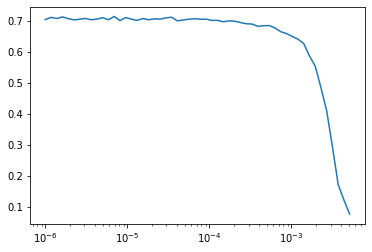

In [35]:
from callbacks import *

run = Runner(cb_funcs=[LR_Find, Recorder])

run.fit(100, learn)
run.recorder.plot(skip_last=5)

We can add all sorts of Callbacks, we can also trigger a Tensorboard run as a Callback:

In [37]:
from functools import partial

model = Classifier(nn.Sequential(
    *get_cnn_layers(raw_feat, OUTPUT_SHAPES, KERNELS, STRIDES)
    ), emb_dims, NUM_CLASSES).to(device)
opt = optim.Adam(model.parameters(), lr=2e-3)

cbfs = [Recorder, partial(AvgStatsCallback,adjusted_accu), partial(Tracker, RUN_PATH)]
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)
run.fit(40, learn)

epoch: 10
train: [0.6974158377017615, tensor(0.3962)]
valid: [0.6996233122689384, tensor(0.3571)]
epoch: 20
train: [0.2831651039843289, tensor(0.9434)]
valid: [0.3708829198564802, tensor(1.)]
epoch: 30
train: [0.06155696904884195, tensor(0.9811)]
valid: [0.00996389878647668, tensor(1.)]
epoch: 40
train: [0.013252086234542559, tensor(1.)]
valid: [0.00019769343946661268, tensor(1.)]


This now has triggered a *run* for Tensorboard and saved it in this folder. We can now have a look at this by typing *tensorboard --logdir=runs* in the Terminal:

![Tensorboard](images/Tensorboard.png)

And that's it for now. I hope the idea of Information Expert Principle is now a bit more familiar, and I could give you some ideas of how to refactor your existing Data Science projects.

Lasse